# Visión artificial
## El muffinómetro

In [7]:
from google.colab import files
import zipfile
import os

#Como estoy trabajando en Google Colab tengo que trabajar con el zip y descomprimirlo
# Subir el archivo comprimido
uploaded = files.upload()

for filename in uploaded.keys():
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall('/content/Image_dataset')

# Listar las carpetas descomprimidas
print("Carpetas descomprimidas en /content/Image_dataset:")
print(os.listdir('/content/Image_dataset'))

# Listar archivos en cada carpeta para verificar
carpeta1 = '/content/Image_dataset/cupcake'
carpeta2 = '/content/Image_dataset/muffin'

Saving Image_dataset.zip to Image_dataset (1).zip
Carpetas descomprimidas en /content/Image_dataset:
['cupcake', 'muffin']


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

1. Descomprima el dataset proporcionado en data/image_dataset.zip.

In [9]:
# Rutas a las carpetas de imágenes
carpeta_muffins = carpeta2
carpeta_cupcake = carpeta1

2. Separe los datos en train y validation (80%/20%).

In [10]:
# Función para listar imágenes con sus etiquetas
def listar_imagenes(carpeta, etiqueta):
    return [[tf.io.gfile.join(carpeta, nombre_archivo), etiqueta]
            for nombre_archivo in tf.io.gfile.listdir(carpeta)
            if nombre_archivo.lower().endswith(('.jpg'))]

# Crear listas de imágenes con sus etiquetas
imagenes_muffins = listar_imagenes(carpeta_muffins, 'muffin')
imagenes_cupcakes = listar_imagenes(carpeta_cupcake, 'cupcake')

# Combinar ambas listas y convertir a DataFrame
df_imagenes = pd.DataFrame(imagenes_muffins + imagenes_cupcakes, columns=['ruta', 'etiqueta'])

# Dividir en conjuntos de entrenamiento y prueba (80/20)
train_df, test_df = train_test_split(df_imagenes, test_size=0.2, stratify=df_imagenes['etiqueta'], random_state=123)

# Mostrar tamaños de los conjuntos de datos
print(f'Tamaño del conjunto de entrenamiento: {len(train_df)}')
print(f'Tamaño del conjunto de prueba: {len(test_df)}')

# Verificar las primeras filas de los conjuntos de entrenamiento y prueba
print("Algunos de los datos del set de entrenamiento: ")
print(train_df.head())
print("Algunos de los datos del set de validación: ")
print(test_df.head())

Tamaño del conjunto de entrenamiento: 1323
Tamaño del conjunto de prueba: 331
Algunos de los datos del set de entrenamiento: 
                                                   ruta etiqueta
354   /content/Image_dataset/muffin/flipped_images (...   muffin
330   /content/Image_dataset/muffin/flipped_images (...   muffin
975   /content/Image_dataset/cupcake/flipped_images ...  cupcake
1015     /content/Image_dataset/cupcake/images (60).jpg  cupcake
232   /content/Image_dataset/muffin/flipped_images (...   muffin
Algunos de los datos del set de validación: 
                                                  ruta etiqueta
911     /content/Image_dataset/cupcake/images (33).jpg  cupcake
507  /content/Image_dataset/muffin/flipped_images (...   muffin
299     /content/Image_dataset/muffin/images (314).jpg   muffin
49   /content/Image_dataset/muffin/flipped_images (...   muffin
999  /content/Image_dataset/cupcake/flipped_image (...  cupcake


3. Entrene un modelo usando la siguiente arquitectura (o similar):

8x conv2d 3x3 \
ReLU \
maxpool 2x2 \
dropout 0.4

12x conv2d 3x3 \
ReLU \
maxpool 2x2 \
dropout 0.4

flatten \
1x dense \
sigmoid


In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Rutas a las carpetas de imágenes
carpeta_muffins = carpeta2
carpeta_cupcake = carpeta1

# Función para listar imágenes con sus etiquetas
def listar_imagenes(carpeta, etiqueta):
    return [[f"{carpeta}/{nombre_archivo}", etiqueta]
            for nombre_archivo in tf.io.gfile.listdir(carpeta)
            if nombre_archivo.lower().endswith(('.jpg'))]

# Crear listas de imágenes con sus etiquetas
imagenes_muffins = listar_imagenes(carpeta_muffins, 'muffin')
imagenes_cupcakes = listar_imagenes(carpeta_cupcake, 'cupcake')

# Combinar ambas listas y convertir a DataFrame
df_imagenes = pd.DataFrame(imagenes_muffins + imagenes_cupcakes, columns=['ruta', 'etiqueta'])

# Dividir en conjuntos de entrenamiento y prueba (80/20)
train_df, test_df = train_test_split(df_imagenes, test_size=0.2, stratify=df_imagenes['etiqueta'], random_state=123)

# Crear generadores de datos para el entrenamiento y la validación
datagen_train = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, zoom_range=0.2, rotation_range=20)
# En el set de entrenamiento modifica levemente las fotos, haciendoles zoom o volteándolas así aprende a detecarlas con variaciones y prevenir el overfitting
datagen_test = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen_train.flow_from_dataframe(
    train_df, x_col='ruta', y_col='etiqueta', target_size=(160, 160),
    class_mode='binary', batch_size=32, shuffle=True
)

test_generator = datagen_test.flow_from_dataframe(
    test_df, x_col='ruta', y_col='etiqueta', target_size=(160, 160),
    class_mode='binary', batch_size=32, shuffle=False
)

inp = Input(shape=(160,160,3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)
x = Conv2D(24, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=output)
model.summary()


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_generator, epochs=15, validation_data=test_generator)

# Evaluar el modelo
loss, accuracy = model.evaluate(test_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


Found 1323 validated image filenames belonging to 2 classes.
Found 331 validated image filenames belonging to 2 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 80, 80, 16)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 80, 80, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 80, 80, 24)        3480      
                                                                 
 max

(4 y 5). Grafique la curva de loss de entrenamiento y validación en función de la epoch. ¿Tiene la forma que esperaba? :Informe la accuracy en el dataset de entrenamiento y el de validación (el modelo debería lograr 80-85% de accuracy en el dataset de validación)


11/11 [==============================] - 2s 168ms/step - loss: 0.3838 - accuracy: 0.8580
Training Loss: 0.412285178899765
Training Accuracy: 0.8374905586242676
Validation Loss: 0.38377153873443604
Validation Accuracy: 0.8580060601234436


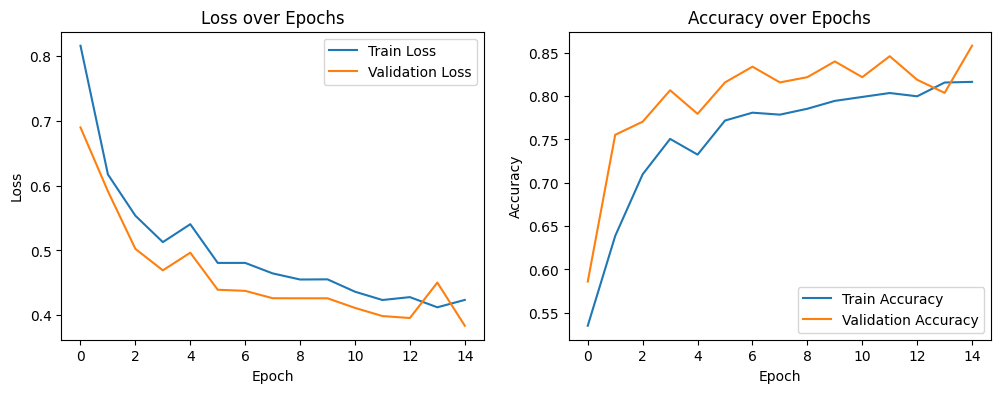

In [20]:
import matplotlib.pyplot as plt

# Evaluar el modelo en los datos de entrenamiento y validación
train_loss, train_accuracy = model.evaluate(train_generator)
val_loss, val_accuracy = model.evaluate(test_generator)

print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")



# Graficar loss y accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



plt.show()

Observando las pérdidas y la precisión del modelo a través de las *epochs* es posible apreciar como las pérdidas tienden a un valor menor a medida que van pasando las épocas y la precisión por el contrario tiende a crecer. En el caso de las pérdidas, la de validación es mayoritariamente menor que la de entrenamiento, y ocurre al revés con la precisión. En resumen parecería ser que el rendimiento del validation es mejor que del de entrenamiento. Esto se puede deber a que yo le aplico severos cambios y transformaciones a los datos de entrenamientom, mientras que a los datos de validación no. Además de que tengo *Dropout* aplicado unicamente al set de entrenamiento, lo que puede bajar la eficiencia y subir la pérdida. 

6. Testee su modelo buscando en internet una imagen de un muffin y una de un cupcake, (estas imágenes no deben estar en el dataset de entrenamiento).


In [21]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Subir una imagen
uploaded = files.upload()

def cargar_y_preprocesar_imagen(ruta_imagen):
    img = image.load_img(ruta_imagen, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def clasificar_imagen(ruta_imagen, modelo):
    img_preprocesada = cargar_y_preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(img_preprocesada)
    if prediccion[0] < 0.5:
        return 'cupcake'
    else:
        return 'muffin'

# Ejemplo de uso
for filename in uploaded.keys():
    clasificacion = clasificar_imagen(filename, model)
    print(f"La imagen {filename} ha sido clasificada como: {clasificacion}")



Saving es_un_mufufukinmuffin.jpeg to es_un_mufufukinmuffin (1).jpeg
1/1 [==============================] - 0s 111ms/step
La imagen es_un_mufufukinmuffin (1).jpeg ha sido clasificada como: muffin


La imagen testeada, fue hecha con IA y es la siguiente:
![Imagen utilizada para probar el modelo](/Users/titigrune/Universidad/FIA/FIA-TP2-2024/entregas/grunewald/data/es_un_mufufukinmuffin.jpeg)
(Es un muffin)


In [23]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Subir una imagen
uploaded = files.upload()

def cargar_y_preprocesar_imagen(ruta_imagen):
    img = image.load_img(ruta_imagen, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def clasificar_imagen(ruta_imagen, modelo):
    img_preprocesada = cargar_y_preprocesar_imagen(ruta_imagen)
    prediccion = modelo.predict(img_preprocesada)
    if prediccion[0] < 0.5:
        return 'cupcake'
    else:
        return 'muffin'

# Ejemplo de uso
for filename in uploaded.keys():
    clasificacion = clasificar_imagen(filename, model)
    print(f"La imagen {filename} ha sido clasificada como: {clasificacion}")

Saving imagen_misteriosa.jpg to imagen_misteriosa (1).jpg
1/1 [==============================] - 0s 31ms/step
La imagen imagen_misteriosa (1).jpg ha sido clasificada como: cupcake


La imagen testeada, fue hecha con IA y es la siguiente:
![Imagen utilizada para probar el modelo](/Users/titigrune/Universidad/FIA/FIA-TP2-2024/entregas/grunewald/data/imagen_misteriosa.jpg)
(Es un cupcake)